In [1]:
# https://www.kaggle.com/c/mercari-price-suggestion-challenge
import os
os.environ['OMP_NUM_THREADS'] = '4'

In [3]:
# used for developing deep learning models
import torch
from torch.autograd import Variable
from torch import optim
#from torch.optim import lr_scheduler
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import math
%matplotlib inline  

In [5]:
train = pd.read_csv('./data/train.tsv', sep='\t')
test = pd.read_csv('./data/test.tsv', sep='\t')

## Data Visualisation

In [7]:
train.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [9]:
train.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [8]:
# check for null
train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

#### Category

In [10]:
def split_cat(text):
    try: return text.split("/")
    except: return ("None", "None", "None")

In [11]:
train['general_cat'], train['subcat_1'], train['subcat_2'] = zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()
test['general_cat'], test['subcat_1'], test['subcat_2'] = zip(*test['category_name'].apply(lambda x: split_cat(x)))
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,Women,Jewelry,Rings
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality


Text(0,0.5,'Frequency')

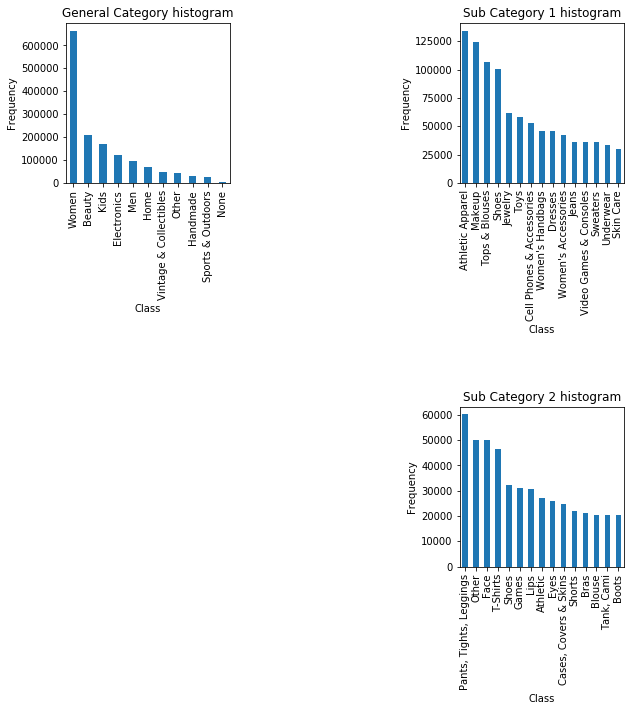

In [17]:
### Plotting some histograms of categorical Variables
plt.figure(figsize=(10,10))
plt.subplot(3,3,1)
count_classes_general_cat = pd.value_counts(train.general_cat, sort = True)
count_classes_general_cat.plot(kind = 'bar')
plt.title("General Category histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
# subcategory 1
plt.subplot(3,3,3)
count_classes_subcat_1 = pd.value_counts(train.subcat_1, sort = True)[:15]
count_classes_subcat_1.plot(kind = 'bar')
plt.title("Sub Category 1 histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
# subcategory 2
plt.subplot(3,3,9)
count_classes_subcat_2 = pd.value_counts(train.subcat_2, sort = True)[:15]
count_classes_subcat_2.plot(kind = 'bar')
plt.title("Sub Category 2 histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [19]:
print("There are %d unique brand names in the training dataset." % train['brand_name'].nunique())

There are 4809 unique brand names in the training dataset.


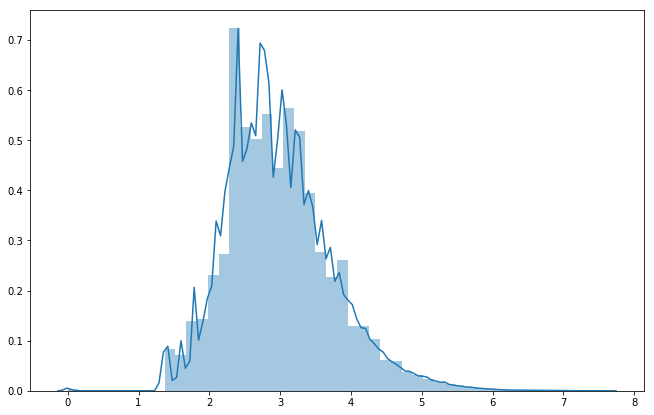

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.distplot(np.log(train['price'].values+1))

## Data Handling

In [20]:
# Loss Function
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [24]:
print("Handling missing values...")
def handle_missing(dataset):
    # Replace na with "None"
    dataset.brand_name.fillna(value="None", inplace=True)
    dataset.item_description.fillna(value="None", inplace=True)
    dataset.category_name.fillna(value="None", inplace=True)
    return (dataset)

train = handle_missing(train)
test = handle_missing(test)
print(train.shape)
print(test.shape)
train.isnull().sum()

Handling missing values...
(1482535, 11)
(693359, 10)


train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
general_cat          0
subcat_1             0
subcat_2             0
dtype: int64

In [25]:
# Encode Categorical Data
def encode_text(column):
    le = LabelEncoder()
    le.fit(np.hstack([train[column], test[column]]))
    train[column+'_index'] = le.transform(train[column])
    test[column+'_index'] = le.transform(test[column])

In [26]:
encode_text('brand_name')
encode_text('general_cat')
encode_text("subcat_1")
encode_text('subcat_2')
encode_text('category_name')

In [27]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2,brand_name_index,general_cat_index,subcat_1_index,subcat_2_index,category_name_index
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,None,1,Size 7,Women,Jewelry,Rings,3361,10,58,667,1206
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,None,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies,3361,7,72,701,900
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag,1094,9,7,382,1001
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,None,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan,3361,10,97,166,1257
4,4,Life after Death,3,Other/Books/Religion & Spirituality,None,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality,3361,7,14,662,861


In [28]:
class Category:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [29]:
# Turn a Unicode string to plain ASCII
import unicodedata
import re
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    #s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def normalizeLine(sentence):
    return [normalizeString(s) for s in sentence.split('\t')]

In [34]:
# normalize each sentence's tokens
def prepareData(lang1,data):
    # new Category object based on column
    input_cat = Category(lang1)
    for sentence in data:
        # normalize
        normalize_line = [normalizeString(s) for s in sentence.split('\t')]
        # 'insert' to each token of sentence to category Object
        input_cat.addSentence(normalize_line[0])
        
    print("Counted words:")
    print(input_cat.name, input_cat.n_words)
    return input_cat

In [31]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    #indexes.append(EOS_token)
    return indexes

In [32]:
# return sequence of token id for a column
def token_fit(column):
    raw_text = np.hstack([(train[column]).str.lower(), (test[column]).str.lower()])
    cat1 = prepareData(column,raw_text)
    print ("adding train data")
    train[column + '_seq'] = [variableFromSentence(cat1,normalizeLine(sentence.lower())[0]) for sentence in train[column]]
    print ("adding test data")
    test[column + '_seq'] = [variableFromSentence(cat1,normalizeLine(sentence.lower())[0]) for sentence in test[column]]

In [33]:
token_fit('name')

Counted words:
name 113421
adding train data
adding test data


In [36]:
token_fit('item_description')

Counted words:
item_description 162434
adding train data
adding test data


In [37]:
#SEQUENCES VARIABLES ANALYSIS
# Find out longest token count of name & desc column
max_name_seq = np.max([np.max(train.name_seq.apply(lambda x: len(x))), np.max(test.name_seq.apply(lambda x: len(x)))])
max_item_description_seq = np.max([np.max(train.item_description_seq.apply(lambda x: len(x)))
                                   , np.max(test.item_description_seq.apply(lambda x: len(x)))])
print("max name seq "+str(max_name_seq))
print("max item desc seq "+str(max_item_description_seq))

max name seq 29
max item desc seq 237


In [38]:
#EMBEDDINGS MAX VALUE
#Base on the histograms, we select the next lengths
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
# find highest index
MAX_TEXT = np.max([np.max(train.name_seq.max()) 
                   , np.max(test.name_seq.max())
                  , np.max(train.item_description_seq.max())
                  , np.max(test.item_description_seq.max())])+2
MAX_GEN_CATEGORY = np.max([train.general_cat_index.max(), test.general_cat_index.max()])+1
MAX_SUB_CAT1_CATEGORY = np.max([train.subcat_1_index.max(), test.subcat_1_index.max()])+1
MAX_SUB_CAT2_CATEGORY = np.max([train.subcat_2_index.max(), test.subcat_2_index.max()])+1
MAX_BRAND = np.max([train.brand_name_index.max(), test.brand_name_index.max()])+1
MAX_CONDITION = np.max([train.item_condition_id.max(), test.item_condition_id.max()])+1
MAX_CATEGORY_NAME = np.max([train.category_name_index.max(), test.category_name_index.max()])+1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x18e3807f0>]],
      dtype=object)

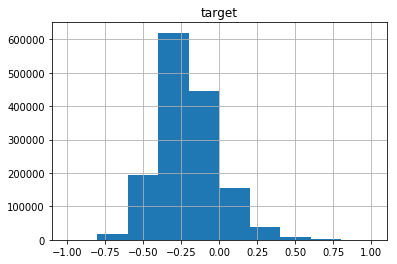

In [45]:
#SCALE target variable
train["target"] = np.log(train.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train["target"] = target_scaler.fit_transform(train.target.values.reshape(-1,1))
pd.DataFrame(train.target).hist()

In [49]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,brand_name_index,general_cat_index,subcat_1_index,subcat_2_index,category_name_index,name_seq,item_description_seq,target
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,None,10.0,1,No description yet,Men,Tops,T-shirts,3361,5,103,774,829,"[2, 3, 4, 5, 6, 7, 8]","[2, 3, 4]",-0.369464
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,3890,1,30,215,86,"[9, 10, 11, 12]","[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...",0.044005
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,4589,10,104,97,1278,"[13, 14, 15]","[36, 37, 38, 39, 40, 17, 41, 11, 39, 42, 43, 8...",-0.369464
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,None,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,3361,3,55,410,503,"[16, 17, 18]","[54, 38, 55, 20, 56, 57, 20, 58, 59, 60, 61, 2...",-0.057699
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,None,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,3361,10,58,542,1205,"[19, 20, 21, 22, 23]","[80, 38, 81, 17, 82]",0.000978


In [50]:
#EXTRACT DEVELOPTMENT TEST
dtrain, dvalid = train_test_split(train, random_state=123, train_size=0.99)
print(dtrain.shape)
print(dvalid.shape)

/Users/setup/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(1467709, 19)
(14826, 19)


In [55]:
def pad(tensor, length):
    if length > tensor.size(0):
        # 
        return torch.cat([tensor, tensor.new(length - tensor.size(0), *tensor.size()[1:]).zero_()])
    else:
        # omit if tensor is longer than specify length
        return torch.split(tensor, length, dim=0)[0]

In [56]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        name, item_desc,brand_name,cat_name,general_category,subcat1_category,subcat2_category, \
        item_condition,shipping,target = sample['name'], sample['item_desc'], sample['brand_name'], \
        sample['cat_name'], sample['general_category'], sample['subcat1_category'], sample['subcat2_category'], \
        sample['item_condition'], sample['shipping'],sample['target']
        #item_desc, brand_name = sample['item_desc'], sample['brand_name']       
        return {'name': pad(torch.from_numpy(np.asarray(name)).long().view(-1),MAX_NAME_SEQ),
                'item_desc': pad(torch.from_numpy(np.asarray(item_desc)).long().view(-1),MAX_ITEM_DESC_SEQ),
               'brand_name':torch.from_numpy(np.asarray(brand_name)),
               'cat_name':torch.from_numpy(np.asarray(cat_name)),
               'general_category':torch.from_numpy(np.asarray(general_category)),
               'subcat1_category':torch.from_numpy(np.asarray(subcat1_category)),
               'subcat2_category':torch.from_numpy(np.asarray(subcat2_category)),
               'item_condition':torch.from_numpy(np.asarray(item_condition)),
               'shipping':torch.torch.from_numpy(np.asarray(shipping)),
               'target':torch.from_numpy(np.asarray(target))}

In [68]:
class MercariDataset(Dataset):
    
    def __init__(self, data_pd, transform=None):
        self.mercari_frame = data_pd
        self.transform = transform
    
    def __len__(self):
        return len(self.mercari_frame)
    
    def __getitem__(self, idx):
        name = [self.mercari_frame.name_seq.iloc[idx]]
        item_desc = [self.mercari_frame.item_description_seq.iloc[idx]]
        brand_name = [self.mercari_frame.brand_name_index.iloc[idx]]
        cat_name = [self.mercari_frame.category_name_index.iloc[idx]]
        general_category = [self.mercari_frame.general_cat_index.iloc[idx]]
        subcat1_category = [self.mercari_frame.subcat_1_index.iloc[idx]]
        subcat2_category = [self.mercari_frame.subcat_2_index.iloc[idx]]
        item_condition = [self.mercari_frame.item_condition_id.iloc[idx]]
        shipping = [self.mercari_frame.shipping.iloc[idx]]
        target = [self.mercari_frame.target.iloc[idx]]
        sample = {'name': name,
                'item_desc': item_desc,
               'brand_name': brand_name,
               'cat_name': cat_name,   
               'general_category': general_category,
               'subcat1_category': subcat1_category,
               'subcat2_category': subcat2_category,
               'item_condition': item_condition,
               'shipping': shipping,
               'target': target}

        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [70]:
mercari_datasets = {'train': MercariDataset(dtrain,transform=transforms.Compose([ToTensor()])), 
                    'val': MercariDataset(dvalid,transform=transforms.Compose([ToTensor()]))
                   }
dataset_sizes = {x: len(mercari_datasets[x]) for x in ['train', 'val']}

In [114]:
mercari_dataloaders = {x: torch.utils.data.DataLoader(mercari_datasets[x], batch_size=50, shuffle=True) 
                                                           for x in ['train', 'val']}

In [115]:
mercari_dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x17766f320>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x1835aed68>}

In [116]:
# Some Useful Time functions
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [136]:
# Model

class RegressionNeural(nn.Module):
    def __init__(self, max_sizes):
        super(RegressionNeural, self).__init__()
        # declare embedding
        self.name_embedding = nn.Embedding(np.asscalar(max_sizes['max_text']), 50)
        self.item_embedding = nn.Embedding(np.asscalar(max_sizes['max_text']), 50)
        self.brand_embedding = nn.Embedding(np.asscalar(max_sizes['max_brand']),10)
        self.gencat_embedding = nn.Embedding(np.asscalar(max_sizes['max_gen_category']), 10)
        self.subcat1_embedding = nn.Embedding(np.asscalar(max_sizes['max_subcat1_category']), 10)
        self.subcat2_embedding = nn.Embedding(np.asscalar(max_sizes['max_subcat2_category']), 10)
        self.condition_embedding = nn.Embedding(np.asscalar(max_sizes['max_condition']), 5)
        # I am adding an embedding just based on Category name without separating it into the 3 pieces
        self.catname_embedding = nn.Embedding(np.asscalar(max_sizes['max_cat_name']), 10)
        
        # convolution for name and item embedding
        self.conv1_name = nn.Conv1d(50, 1, 2, stride=1)
#         self.conv2_name = nn.Conv1d(16, 8, 2, stride=1)
#         self.conv3_name = nn.Conv1d(8,4,2, stride=1)
        
        self.conv1_item_desc = nn.Conv1d(50, 1, 5, stride=5)
#         self.conv2_item_desc = nn.Conv1d(64, 16, 5, stride=1)
#         self.conv3_item_desc = nn.Conv1d(16, 4, 5, stride=1)
        
        self.dropout = nn.Dropout(p=0.2)
        
        self.input_fc1_count = 50 #1214 #206 #16+10+10+10+10+5+1
        self.fc1 = nn.Linear(self.input_fc1_count, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x, batchsize):
        embed_name = self.name_embedding(x['name'])
        # I am swapping the Embedding size and the sequence length so that convolution is done across multiple words
        # using all the embeddings.  Without this, the 1-D convolution was doing convolution using all the words but
        # a slice of embeddings.  I don't think that is the correct way to do 1D convolution.
        embed_name = F.relu(self.conv1_name(embed_name.transpose(1,2)))

        embed_item = self.item_embedding(x['item_desc'])
        embed_item = F.relu(self.conv1_item_desc(embed_item.transpose(1,2)))

        embed_brand = self.brand_embedding(x['brand_name'])
        embed_gencat = self.gencat_embedding(x['general_category'])
        embed_subcat1 = self.subcat1_embedding(x['subcat1_category'])
        embed_subcat2 = self.subcat2_embedding(x['subcat2_category'])
        embed_condition = self.condition_embedding(x['item_condition'])
        embed_catname = self.catname_embedding(x['cat_name'])

        # 10 + 10 + 5 + 25 + 10 + 1 Figure out this input shape why 50
        out = torch.cat((embed_brand.view(batchsize,-1), embed_catname.view(batchsize, -1),
                         embed_condition.view(batchsize,-1), embed_name.view(batchsize,-1),
                         embed_item.view(batchsize,-1),x['shipping']),1)

        out = (self.fc1(out))
        out = F.relu(self.dropout(out))
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

In [137]:
max_sizes = {'max_text':MAX_TEXT,'max_name_seq':MAX_NAME_SEQ,'max_item_desc_seq':MAX_ITEM_DESC_SEQ, \
             'max_brand':MAX_BRAND,'max_cat_name':MAX_CATEGORY_NAME,'max_gen_category':MAX_GEN_CATEGORY,\
             'max_subcat1_category':MAX_SUB_CAT1_CATEGORY,'max_subcat2_category':MAX_SUB_CAT2_CATEGORY,\
             'max_condition':MAX_CONDITION} 

deep_learn_model = RegressionNeural(max_sizes)

In [138]:
def train_model(model, criterion, optimizer, num_epochs=1, print_every = 100):
    start = time.time()
    
    best_acc = 0.0
    print_loss_total = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phrase
        for phrase in ['train', 'val']:
            if phrase == 'train':
                model.train(True) # Train Mode
            else:
                model.train(False) # Evaluation Mode
            
            running_loss = 0.0
            num_batches = dataset_sizes[phrase]/50.
            
            # Iterate over data, sample_batched is a dictionary of tensor
            for i_batch, sample_batched in enumerate(mercari_dataloaders[phrase]):
                
                inputs = {'name':Variable(sample_batched['name']), 'item_desc':Variable(sample_batched['item_desc']), \
                    'brand_name':Variable(sample_batched['brand_name']), \
                    'cat_name':Variable(sample_batched['cat_name']), \
                    'general_category':Variable(sample_batched['general_category']), \
                    'subcat1_category':Variable(sample_batched['subcat1_category']), \
                    'subcat2_category':Variable(sample_batched['subcat2_category']), \
                    'item_condition':Variable(sample_batched['item_condition']), \
                    'shipping':Variable(sample_batched['shipping'].float())}
                
                # prices is our label
                prices = Variable(sample_batched['target'].float())
                batch_size = len(sample_batched['shipping'])
                
                # zero gradient
                optimizer.zero_grad()
                
                # forward pass
                outputs = model(inputs, batch_size)
                loss = criterion(outputs, prices)
                
                # backward prop and update
                if phrase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                # statistic only
                running_loss += loss.data[0]
                print_loss_total += loss.data[0]
                
                if (i_batch+1) % print_every == 0:
                    print_loss_avg = print_loss_total / print_every
                    print_loss_total = 0
                    #print (i_batch / num_batches, i_batch, num_batches)
                    print('%s (%d %d%%) %.4f' % (timeSince(start, i_batch / num_batches), \
                                                 i_batch, i_batch / num_batches*100, print_loss_avg))
                    
            epoch_loss = running_loss / num_batches
            
            print('{} Loss: {:.4f}'.format(phrase,epoch_loss))
            
        print()
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    # load best model weights
    #model.load_state_dict(best_model_wts)
    return model                         

In [139]:
criterion = nn.MSELoss()

optimizer_ft = optim.SGD(deep_learn_model.parameters(), lr=0.001, momentum=0.9)
#optimizer_ft = optim.SGD(deep_learn_model.parameters(), lr=0.005)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
train_model(deep_learn_model,criterion,optimizer_ft)

Epoch 0/0
----------
0m 7s (- 38m 4s) (99 0%) 0.0547
0m 15s (- 37m 26s) (199 0%) 0.0462
0m 22s (- 36m 47s) (299 1%) 0.0413
0m 30s (- 36m 33s) (399 1%) 0.0418
0m 37s (- 36m 7s) (499 1%) 0.0408
0m 44s (- 35m 59s) (599 2%) 0.0413
0m 52s (- 35m 49s) (699 2%) 0.0394
0m 59s (- 35m 36s) (799 2%) 0.0383
1m 7s (- 35m 28s) (899 3%) 0.0398
1m 14s (- 35m 19s) (999 3%) 0.0386
1m 22s (- 35m 16s) (1099 3%) 0.0417
1m 30s (- 35m 16s) (1199 4%) 0.0379
1m 38s (- 35m 17s) (1299 4%) 0.0395
1m 45s (- 35m 15s) (1399 4%) 0.0382
1m 53s (- 35m 12s) (1499 5%) 0.0388
2m 1s (- 35m 7s) (1599 5%) 0.0373
2m 9s (- 35m 5s) (1699 5%) 0.0391
2m 17s (- 35m 5s) (1799 6%) 0.0379
2m 25s (- 35m 5s) (1899 6%) 0.0366
2m 33s (- 35m 6s) (1999 6%) 0.0391
2m 42s (- 35m 4s) (2099 7%) 0.0386
2m 50s (- 35m 4s) (2199 7%) 0.0389
2m 58s (- 35m 2s) (2299 7%) 0.0393
3m 6s (- 34m 59s) (2399 8%) 0.0357
3m 15s (- 34m 58s) (2499 8%) 0.0376
3m 23s (- 34m 57s) (2599 8%) 0.0369
3m 32s (- 34m 54s) (2699 9%) 0.0374
3m 40s (- 34m 51s) (2799 9%) 0.03

37m 39s (- 13m 3s) (21799 74%) 0.0357
37m 52s (- 12m 53s) (21899 74%) 0.0363
38m 4s (- 12m 43s) (21999 74%) 0.0349
38m 17s (- 12m 34s) (22099 75%) 0.0357
38m 29s (- 12m 24s) (22199 75%) 0.0354
38m 42s (- 12m 14s) (22299 75%) 0.0346
38m 55s (- 12m 5s) (22399 76%) 0.0336
39m 7s (- 11m 55s) (22499 76%) 0.0347
39m 20s (- 11m 45s) (22599 76%) 0.0338
39m 32s (- 11m 35s) (22699 77%) 0.0342
39m 45s (- 11m 25s) (22799 77%) 0.0343
39m 58s (- 11m 16s) (22899 78%) 0.0352
40m 10s (- 11m 6s) (22999 78%) 0.0366
40m 23s (- 10m 56s) (23099 78%) 0.0347
40m 36s (- 10m 46s) (23199 79%) 0.0331
40m 49s (- 10m 36s) (23299 79%) 0.0344
41m 1s (- 10m 26s) (23399 79%) 0.0354
41m 14s (- 10m 16s) (23499 80%) 0.0362
41m 27s (- 10m 6s) (23599 80%) 0.0345
41m 40s (- 9m 56s) (23699 80%) 0.0363
41m 52s (- 9m 46s) (23799 81%) 0.0355
42m 5s (- 9m 36s) (23899 81%) 0.0327
42m 18s (- 9m 26s) (23999 81%) 0.0352
42m 31s (- 9m 16s) (24099 82%) 0.0339
42m 44s (- 9m 6s) (24199 82%) 0.0334
42m 56s (- 8m 56s) (24299 82%) 0.0341
43

RegressionNeural(
  (name_embedding): Embedding(162417, 50)
  (item_embedding): Embedding(162417, 50)
  (brand_embedding): Embedding(5290, 10)
  (gencat_embedding): Embedding(11, 10)
  (subcat1_embedding): Embedding(114, 10)
  (subcat2_embedding): Embedding(883, 10)
  (condition_embedding): Embedding(6, 5)
  (catname_embedding): Embedding(1311, 10)
  (conv1_name): Conv1d(50, 1, kernel_size=(2,), stride=(1,))
  (conv1_item_desc): Conv1d(50, 1, kernel_size=(5,), stride=(5,))
  (dropout): Dropout(p=0.2)
  (fc1): Linear(in_features=50, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [131]:
deep_learn_model.forward()

<bound method Module.forward of RegressionNeural(
  (name_embedding): Embedding(162417, 50)
  (item_embedding): Embedding(162417, 50)
  (brand_embedding): Embedding(5290, 10)
  (gencat_embedding): Embedding(11, 10)
  (subcat1_embedding): Embedding(114, 10)
  (subcat2_embedding): Embedding(883, 10)
  (condition_embedding): Embedding(6, 5)
  (catname_embedding): Embedding(1311, 10)
  (conv1_name): Conv1d(50, 1, kernel_size=(2,), stride=(1,))
  (conv1_item_desc): Conv1d(50, 1, kernel_size=(5,), stride=(5,))
  (dropout): Dropout(p=0.2)
  (fc1): Linear(in_features=50, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)>

In [141]:
# Validate the model results against validation data
def validate(model, print_every = 20, phase = 'val'):
    start = time.time()
    running_loss = 0
    print_loss_total = 0
    num_batches = dataset_sizes[phase]/50.
    y_pred_full = np.array([])
    y_true_full = np.array([])
    for i_batch, sample_batched in enumerate(mercari_dataloaders[phase]): 
    # get the inputs
        inputs = {'name':Variable(sample_batched['name']), 'item_desc':Variable(sample_batched['item_desc']), \
            'brand_name':Variable(sample_batched['brand_name']), \
            'cat_name':Variable(sample_batched['cat_name']), \
            'general_category':Variable(sample_batched['general_category']), \
            'subcat1_category':Variable(sample_batched['subcat1_category']), \
            'subcat2_category':Variable(sample_batched['subcat2_category']), \
            'item_condition':Variable(sample_batched['item_condition']), \
            'shipping':Variable(sample_batched['shipping'].float())}
        prices = Variable(sample_batched['target'].float())   
        batch_size = len(sample_batched['shipping'])

        # forward
        outputs = model(inputs,batch_size)
        val_preds = target_scaler.inverse_transform(outputs.data.numpy())
        val_preds = np.exp(val_preds)-1
        val_true =  target_scaler.inverse_transform(prices.data.numpy())
        val_true = np.exp(val_true)-1

        #mean_absolute_error, mean_squared_log_error
        y_true = val_true[:,0]
        y_pred = val_preds[:,0]
        y_true_full = np.append(y_true_full,y_true)
        y_pred_full= np.append(y_pred_full,y_pred)
        
        loss = criterion(outputs, prices)
        #print ("output size", val_preds.shape)
        #print ("ypred_full",len(y_pred_full))

        # statistics
        running_loss += loss.data[0]
        print_loss_total += loss.data[0]
        #print("loss data shape", loss.data.size())
        #print("running loss", running_loss)
        #running_corrects += torch.sum(preds == labels.data)


        if (i_batch+1) % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            #print (i_batch / num_batches, i_batch, num_batches)
            print('%s (%d %d%%) %.4f' % (timeSince(start, i_batch / num_batches), \
                                         i_batch, i_batch / num_batches*100, print_loss_avg))

    v_rmsle = rmsle(y_true_full, y_pred_full)
    print(" RMSLE error on dev validate: "+str(v_rmsle))
    print("total loss", running_loss / num_batches ) 
    return y_pred_full, y_true_full

In [142]:
# You can see the RMSE loss on validation data is very poor.  
y_pred_val, y_true_val = validate(deep_learn_model)

0m 0s (- 0m 3s) (19 6%) 0.0322
0m 0s (- 0m 3s) (39 13%) 0.0320
0m 0s (- 0m 2s) (59 19%) 0.0309
0m 0s (- 0m 2s) (79 26%) 0.0300
0m 1s (- 0m 2s) (99 33%) 0.0336
0m 1s (- 0m 2s) (119 40%) 0.0321
0m 1s (- 0m 1s) (139 46%) 0.0340
0m 1s (- 0m 1s) (159 53%) 0.0345
0m 2s (- 0m 1s) (179 60%) 0.0344
0m 2s (- 0m 1s) (199 67%) 0.0324
0m 2s (- 0m 0s) (219 73%) 0.0328
0m 2s (- 0m 0s) (239 80%) 0.0338
0m 3s (- 0m 0s) (259 87%) 0.0343
0m 3s (- 0m 0s) (279 94%) 0.0319
 RMSLE error on dev validate: 0.6896071053650803
total loss 0.03295604181779343


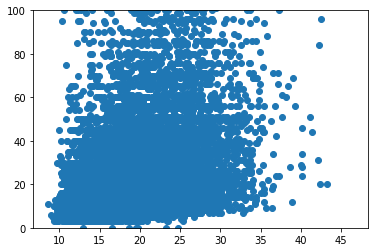

In [143]:
axes = plt.gca()
axes.set_ylim([0,100])
plt.scatter(y_pred_val,y_true_val)

In [144]:
y_pred_val.mean(),y_true_val.mean()

(19.41588826657435, 26.559826895435794)

In [ ]:
test_set = MercariDataset(test,transform=transforms.Compose([ToTensor()])
test_loader = torch.utils.data.DataLoader(test_set, batch_size=50, shuffle=False) 


In [ ]:

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))